## Is your cat tappy or persian?

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "tappy cat"
1. Use DuckDuckGo to search for images of "persian cat"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of tappy and persian cats

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a tappy cat photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Tabby cat', max_images=1)
urls[0]

Searching for 'Tabby cat'


'https://www.thesprucepets.com/thmb/o76tYUlS1kJCb8H9VCyL4249ayo=/2036x1473/filters:fill(auto,1)/GettyImages-584178259-5a721010119fa80037ed3cce.jpg'

...and then download a URL and take a look at it:

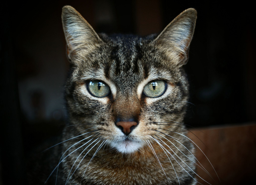

In [4]:
from fastdownload import download_url
dest = 'tappy.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "persian cats":

Searching for 'persian cat'


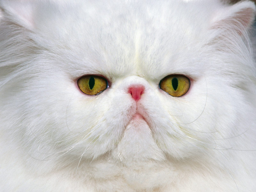

In [6]:
download_url(search_images('persian cat', max_images=1)[0], 'persian.jpg', show_progress=False)
Image.open('persian.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "tappy" and "persian" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'tappy cat','persian cat'
path = Path('tappy_or_persian')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'tappy cat photo'
Searching for 'tappy cat sun photo'
Searching for 'tappy cat shade photo'
Searching for 'persian cat photo'
Searching for 'persian cat sun photo'
Searching for 'persian cat shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

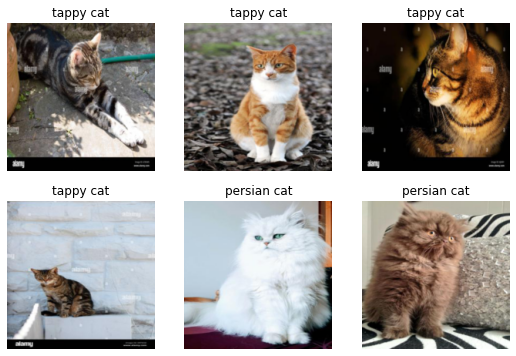

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:41<00:00, 1.13MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.044759,0.158641,0.038462,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.364012,0.162175,0.076923,00:08
1,0.222603,0.326788,0.115385,00:08
2,0.155097,0.237758,0.076923,00:09


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [13]:
is_tappy,_,probs = learn.predict(PILImage.create('atat.jpg'))
print(f"This is a: {is_tappy}.")
print(f"Probability it's a persian: {probs[0]:.4f}")

This is a: persian cat.
Probability it's a persian: 0.9141


This project is an application of fastai deep learning course lecture 1.